![CCSP 2 0 Logo File](https://user-images.githubusercontent.com/22593272/183507755-02baef2f-ab3e-4b2d-a180-694e9cf0043d.png)

## Package Import and Defining Required Functions

In [1]:
%%time
# Import packages block
from IPython.utils import io
import ctypes
import math
import statistics
import time
import tkinter as tk
from multiprocessing import freeze_support
import os
from sys import stdout
from tkinter.filedialog import asksaveasfile
from tkinter import *
from tkinter import messagebox, simpledialog, filedialog
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import pubchempy as pcp
import sklearn
from mordred import Calculator, descriptors
from rdkit import Chem
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedShuffleSplit,
    cross_val_predict,
    cross_validate
)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.utils import shuffle


def select_input_files():
    """
    Creates a series of prompts to select Excel notebooks for training, testing and target molecules; can randomly divide a data set if the training and testing molecules are not pre-split by user.
    
    Input Parameters:
        None
    
    Intermediate Parameters: 
        TestTrain file (Excel workbook): Excel workbook with molecule names, identifiers (CID, InChI or SMILES), and experimental CCS values.
        Target file (Excel workbook): Excel workbook with molecule names and identifiers (CID, InChI or SMILES).
        split_percentage (float): a number between 0 or 100.
        
        or
        
        Train file (Excel workbook): Excel workbook with molecule names, identifiers (CID, InChI or SMILES), and experimental CCS values.
        Test file (Excel workbook): Excel workbook with molecule names, identifiers (CID, InChI or SMILES), and experimental CCS values.
        Target file (Excel workbook): Excel workbook with molecule names and identifiers (CID, InChI or SMILES).
       
        
    Returns:
        Train_Book (Pandas DataFrame): Table of training molecule names, identifiers (CID, InChI or SMILES), and experimental CCS values.
        Test_Book (Pandas DataFrame): Table of test molecule names, identifiers (CID, InChI or SMILES), and experimental CCS values.
        Target_Book (Pandas DataFrame): Table of target molecule names and identifiers (CID, InChI or SMILES).
    
    """
    win = Tk()
    #Define the geometry of the function
    win.geometry("750x250")
    combined_boolean = messagebox.askyesno("Question","Are your training and test sets already split into separate files?")
    if combined_boolean is False:
        ctypes.windll.user32.MessageBoxW(0, 
                                         "Select the Excel workbook with your combined training and test data, and the data will be randomly split for you. Make sure you have the three following columns: \n \n 'Compound Name': Chemical names or labels.  \n \n 'Input': Chemical identifiers as InChI, CID, or isomeric SMILES.  \n \n 'CCS': Experimental CCS values.", "CCSP 2.0", 1)
        TrainTest_Book = pd.read_excel(filedialog.askopenfilename())
        split_percentage = simpledialog.askfloat("Question","What percentage of the input molecules would you like to allocate towards training? [Between 0 and 100]", minvalue=0.0, maxvalue=100.0)    
        Rand_Master = TrainTest_Book.reindex(np.random.permutation(TrainTest_Book.index))
        Train_Book = Rand_Master.sample(frac = split_percentage/100)
        Test_Book = pd.concat([TrainTest_Book, Train_Book]).drop_duplicates(keep=False)
        ctypes.windll.user32.MessageBoxW(0, "Select the Excel workbook with your target compounds. Make sure you have the two following columns: \n \n 'Compound Name': Chemical names or labels. \n \n 'Input': Chemical identifiers as InChI, CID, or isomeric SMILES.", "CCSP 2.0", 1)
        Target_Book = pd.read_excel(filedialog.askopenfilename())
    if combined_boolean is True:
        ctypes.windll.user32.MessageBoxW(0, "Select the Excel workbook with your training data. Make sure you have the three following columns: \n \n 'Compound Name': Chemical names or labels. \n \n 'Input': Chemical identifiers as InChI, CID, or isomeric SMILES. \n \n 'CCS': Experimental CCS values.", "CCSP 2.0", 1)
        Train_Book = pd.read_excel(filedialog.askopenfilename())
        ctypes.windll.user32.MessageBoxW(0, "Select the Excel workbook with your test data. Make sure you have the three following columns: \n \n 'Compound Name': Chemical names or labels. \n \n 'Input': Chemical identifiers as InChI, CID, or isomeric SMILES. \n \n 'CCS': Experimental CCS values.", "CCSP 2.0", 1)
        Test_Book = pd.read_excel(filedialog.askopenfilename())
        ctypes.windll.user32.MessageBoxW(0, "Select the Excel workbook with your target compounds. Make sure you have the two following columns: \n \n 'Compound Name': Chemical names or labels. \n \n 'Input': Chemical identifiers as InChI, CID, or isomeric SMILES.", "CCSP 2.0", 1)
        Target_Book = pd.read_excel(filedialog.askopenfilename())  
    win.destroy()
    return Train_Book, Test_Book, Target_Book

def check_inputs(Book, column_title='Input'):
    """
    Determines input identifier type (CID, InChI or SMILES) and checks for any invalid inputs.
    
    Parameters:
        Book (Pandas DataFrame): Table with a column containing input identifiers (CID, InChI or SMILES).
        column_title (string): The title of the column containing input identifiers; 'Input' by default.
        
    Returns:
        input_type (string): Type of input identifiers used ("CID", "InChI" or "SMILES").
        input_errors (list): List of identifiers that are invalid.
    
    """
    input_errors = []
    if type(list(Book[column_title])[0]) is np.int64:
        input_type = 'CID'
        for i in Book[column_title]:
            compound = pcp.get_compounds(i, 'cid')
            if Chem.MolFromSmiles(compound[0].isomeric_smiles) is None:
                input_errors.append(i)
    elif 'InChI' in list(Book[column_title])[0]:
        input_type = 'InChI'
        for i in Book[column_title]:
            if Chem.MolFromInchi(i) is None:
                input_errors.append(i)
    else:
        input_type = "SMILES"
        for i in Book[column_title]:
            if Chem.MolFromSmiles(i) is None:
                input_errors.append(i)
                
    return input_type, input_errors

def calculate_descriptors(input_list, input_type='InChI'):
    """
    Calculates Mordred molecular descriptors from input identifiers (CID, InChI or SMILES).
    
    Parameters:
        input_list (Pandas Series): List of input identifiers (CID, InChI or SMILES) of the same type.
        input_type (string): The type of input identifiers; 'InChI' by default.
        
    Returns:
        descriptor_list (Mordred DataFrame): Table of molecular descriptors for each input molecule identifier provided.
    
    """
    if input_type=='InChI':
        mol_list = [Chem.MolFromInchi(i) for i in input_list]
    if input_type=='SMILES':
        mol_list = [Chem.MolFromSmiles(i) for i in input_list]
    if input_type=='CID':
        compounds_list = pcp.get_compounds(input_list, 'cid')
        mol_list = [Chem.MolFromSmiles(i.isomeric_smiles) for i in compounds_list]
    calc = Calculator(descriptors, ignore_3D=True)
    with io.capture_output() as captured:
        descriptor_list = calc.pandas(mol_list)
    return descriptor_list

def variable_assigner(Train_Book, Test_Book, Target_Book, column_title='Input', train_input_type="InChI", test_input_type="InChI", target_input_type="InChI"):
    """
    Constructs input matrices for model development.
    
    Parameters:
        Train_Book (Pandas DataFrame): Table of training molecule names, identifiers (CID, InChI or SMILES), and experimental CCS values.
        Test_Book (Pandas DataFrame): Table of test molecule names, identifiers (CID, InChI or SMILES), and experimental CCS values.
        Target_Book (Pandas DataFrame): Table of target molecule names and identifiers (CID, InChI or SMILES).
        column_title (string): The title of the column containing input identifiers; 'Input' by default.
        train_input_type (string): Type of input identifiers used ("CID", "InChI" or "SMILES"); "InChI" by default.
        test_input_type (string): Type of input identifiers used ("CID", "InChI" or "SMILES"); "InChI" by default.
        target_input_type (string): Type of input identifiers used ("CID", "InChI" or "SMILES"); "InChI" by default.
        
    Returns:
        X_train (Mordred DataFrame): Table of molecular descriptors for each input molecule identifier provided.
        y_train (list): List of experimental CCS values.
        X_test (Mordred DataFrame): Table of molecular descriptors for each input molecule identifier provided.
        y_test (list): List of experimental CCS values.
        X_target (Mordred DataFrame): Table of molecular descriptors for each input molecule identifier provided.
    
    """
    print("Preparing descriptor matrices from input lists...")
    print("     Calculating X_train descriptors...")
    X_train = calculate_descriptors(Train_Book[column_title], train_input_type)
    print("     Calculating X_test descriptors...")
    X_test = calculate_descriptors(Test_Book[column_title], test_input_type)
    print("     Calculating X_target descriptors...")
    X_target = calculate_descriptors(Target_Book[column_title], target_input_type)
    print("All descriptor matrices completed. \n")
    print("Assigning CCS lists to y_train and y_test matrices...")
    y_train = list(Train_Book['CCS'])
    y_test = list(Test_Book['CCS'])
    print("Y matrices prepared. \n")
    return X_train, y_train, X_test, y_test, X_target


def clean_up_descriptors(input_frame):
    """
    Removes non-numerical molecular descriptors from a matrix.
    
    Parameters:
        input_frame (Mordred DataFrame): Table of molecular descriptors.
        
    Returns:
        output_frame (Mordred DataFrame): Table of molecular descriptors after removing non-numerical descriptors.
    
    """
    start_length = len(input_frame.columns)
    output_frame = input_frame.copy().select_dtypes(['number'])
    end_length = len(output_frame.columns)
    print("          Number of inapplicable descriptors: ", start_length-end_length, "\n")
    return output_frame

def drop_constant_column(input_frame):
    """ 
    Removes the columns of a Mordred dataframe that are constant for all rows.
        
    Parameters:
        input_frame (Mordred DataFrame): Table of molecular descriptors.
        
    Returns:
        output_frame (Mordred DataFrame): Table of molecular descriptors after removing constant descriptors.
    """
    start_len = len(input_frame)
    output_frame = input_frame.loc[:, (input_frame != input_frame.iloc[0]).any()]
    end_len = len(output_frame)
    print("          Number of constant descriptors removed: ", start_len-end_len, "\n")
    return output_frame

def removeoutlier(input_frame1, input_frame2, threshold):
    """ 
    Removes molecular descriptor columns from a Mordred dataframe if they contain outlier values when compared to the corresponding column in a reference Mordred dataframe.
        
    Parameters:
        input_frame1 (Mordred DataFrame): Table of molecular descriptors to be inspected.
        input_frame2 (Mordred DataFrame): Table of molecular descriptors to serve as a reference.
        threshold (float): The z-score required for a value to be considered an outlier [(val-mean)/std dev].
        
    Returns:
        output_frame1 (Mordred DataFrame): Table of molecular descriptors after removing columns with outling descriptors.
        output_frame2 (Mordred DataFrame): Table of molecular descriptors after removing columns with outling descriptors.
        
    """
    input_frame1_temporary = input_frame1.copy()
    input_frame2_temporary = input_frame2.copy()
    removed_count = 0
    for i in input_frame2.columns:
        if max(input_frame1[i]) > statistics.mean(input_frame2[i])+threshold*statistics.stdev(input_frame2[i]) or min(input_frame1[i]) < statistics.mean(input_frame2[i])-threshold*statistics.stdev(input_frame2[i]):
            input_frame1_temporary.drop(columns = i)
            input_frame2_temporary.drop(columns = i)
            removed_count = removed_count+1
    output_frame1 = input_frame1_temporary
    output_frame2 = input_frame2_temporary
    print("     Number of descriptors dropped due to outlier function: ", removed_count, "\n")
    return output_frame1, output_frame2

def svr_model_linear(X_train, y_train, C_list = [2**(i) for i in range(-8,-1)], epsilon_list = [0.5, 1, 5]):
    """ 
    Constructs a linear support vector regression model with hyperparameter optimization.
        
    Parameters:
        X_train (Mordred DataFrame): Table of molecular descriptors.
        y_train (list): List of experimental CCS values.
        C_list (list of floats) = GridSearch options for cost hyperparameter; deflaut is [2**(i) for i in range(-8,-1)].
        epsilon_list (list of floats) = GridSearch options for epsilon hyperparameter; deflaut is [0.5, 1, 5].
        
    Returns:
        best_svr (sklearn.svm._classes.SVR object): The optimium SVR model with hyperparameters and weights selected through cross-validation.
        scores (dictionary): The results of the GridSearchCV trials for each C and epsilon pair.
        grid_result (sklearn.model_selection._search.GridSearchCV object): The GridSearchCV object that contains the parameters used to set up the hyperparameter optimization.
        y_train_cross_validation (numpy.ndarray object): The predicted CCS values of the training molecules following k-fold cross-validation.
        
    """
    print("     Performing grid search hyperparamter optimization...")
    gsc = GridSearchCV(
        estimator=SVR(kernel='linear'),
        param_grid={'C':  C_list, 'epsilon': epsilon_list,},
        cv=5, scoring='neg_root_mean_squared_error', verbose=False, n_jobs=-1)
    grid_result = gsc.fit(X_train, y_train)
    print("     Grid search completed.\n")
    best_params = grid_result.best_params_
    print("     Fitting SVR model...")
    best_svr = SVR(kernel='linear', C=best_params["C"], epsilon=best_params["epsilon"],
                   coef0=0.1, shrinking=True,
                   tol=0.001, cache_size=500, verbose=False, max_iter=-1)
    print("     SVR model constructed.\n")
    print("     Performing k-fold cross-validation...")
    scoring = {'abs_error': 'neg_mean_absolute_error','squared_error': 'neg_mean_squared_error'}
    scores = cross_validate(best_svr, X_train, y_train, cv=5, scoring=scoring, return_train_score=True, n_jobs=-1)
    y_train_cross_validation = cross_val_predict(best_svr, X_train, y_train, cv=5, n_jobs=-1, verbose=False)
    print("     Cross-validation completed.\n")
    return best_svr, scores, grid_result, y_train_cross_validation

def initial_ccs_prediction(X_train, y_train, X_test, y_test, X_target, remove_outlier=False, threshold=1000):
    """
    Subscribed (“external”) function that uses previously described nested ("internal") functions to predict CCS values with a linear SVR model.

    Parameters:
        X_train (Mordred DataFrame): Table of molecular descriptors for the training molecules.
        y_train (list): List of experimental CCS values for the training molecules.
        X_test (Mordred DataFrame): Table of molecular descriptors for the test molecules.
        y_test (list): List of experimental CCS values for the test molecules.
        X_target (Mordred DataFrame): Table of molecular descriptors for the target molecules.
        remove_outlier (boolean): Determines whether to apply the removeoutlier function; default is False.
        threshold (float): The z-score required for a value to be considered an outlier [(val-mean)/std dev]; default is 1000 when remove_outlier is True.

    Nested functions:
        clean_up_descriptors
        drop_constant_column
        removeoutlier
        svr_model_linear

    Returns:
        X_train_clean (Mordred DataFrame): Table of training molecular descriptors after removing non-numerical and constant descriptors.
        X_test_clean (Mordred DataFrame): Table of test molecular descriptors after removing non-numerical and constant descriptors.
        X_target_clean (Mordred DataFrame): Table of target molecular descriptors after removing non-numerical and constant descriptors.
        X_train_scaled (numpy.ndarray object): Array of training molecular descriptors following column-wise z-transformation.
        model (sklearn.svm._classes.SVR object): The optimium SVR model with hyperparameters and weights selected through cross-validation.
        grid_results (sklearn.model_selection._search.GridSearchCV object): The GridSearchCV object that contains the parameters used to set up the hyperparameter optimization.
        y_train_predicted (numpy.ndarray object): The predicted CCS values of training molecules using the SVR model.
        y_train_cross_validation (numpy.ndarray object): The predicted CCS values of training molecules following k-fold cross-validation.
        y_test_predicted (numpy.ndarray object): The predicted CCS values of test molecules using the SVR model.
        y_target_predicted (numpy.ndarray object): The predicted CCS values of target molecules using the SVR model.
     
    """
    print("Checking for constant and inapplicable descriptors... \n")
    print("     Investigating X_train matrix for inapplicable descriptors...")
    X_train_clean = clean_up_descriptors(X_train)
    print("     Investigating X_train matrix for constant descriptors...")
    X_train_clean = drop_constant_column(X_train_clean)
    print("     Investigating X_test matrix for inapplicable descriptors...")
    X_test_clean = clean_up_descriptors(X_test)
    print("     Investigating X_target matrix for inapplicable descriptors...")
    X_target_clean = clean_up_descriptors(X_target)
    common_columns = [col for col in set(X_train_clean.columns).intersection(X_test_clean.columns).intersection(X_target_clean.columns)]
    print("Constant and inapplicable descriptors successfully filtered. \n")
    X_train_clean, X_test_clean, X_target_clean = X_train_clean[common_columns], X_test_clean[common_columns], X_target_clean[common_columns]
    if remove_outlier==True:
        print("Investigating X_test for descriptors with significant outliers...")
        X_test_clean, X_train_clean = removeoutlier(X_test_clean, X_train_clean, threshold)
        print("Investigating X_target for descriptors with significant outliers...")
        X_target_clean, X_train_clean = removeoutlier(X_target_clean, X_train_clean, threshold)
    common_columns = [col for col in set(X_train_clean.columns).intersection(X_test_clean.columns).intersection(X_target_clean.columns)]
    X_train_clean, X_test_clean, X_target_clean = X_train_clean[common_columns], X_test_clean[common_columns], X_target_clean[common_columns] 
    print("Scaling descriptor matrices...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_clean)
    X_test_scaled = scaler.transform(X_test_clean)
    X_target_scaled = scaler.transform(X_target_clean)
    print("Descriptor matrices scaled. \n")
    print("Building an SVR model using all applicable Mordred descriptors... \n")
    model, scores, grid_results, y_train_cross_validation = svr_model_linear(X_train_scaled, y_train)
    print("Model completed.\n")
    print("Predicting CCS values...")
    model.fit(X_train_scaled, y_train)
    y_train_predicted = model.predict(X_train_scaled)
    y_test_predicted = model.predict(X_test_scaled)
    y_target_predicted = model.predict(X_target_scaled)
    print("All predictions completed.\n")
    return X_train_clean, X_test_clean, X_target_clean, X_train_scaled, model, grid_results, y_train_predicted, y_train_cross_validation, y_test_predicted, y_target_predicted
    
def regression_metrics(true_values, predicted_values):
    """ 
    Calculates root mean squared error (RMSE), median relative error (MRE), and goodness of fit (R^2)/goodness of prediction (Q^2) from a set of predicted values and a corresponding set of true values.
        
    Parameters:
        true_values (numpy.ndarray object or list): Ground truth (correct) values.
        predicted_values (numpy.ndarray object or list): Estimated values.
        
    Returns:
        RMSE (float): Root mean squared error between true and predicted values.
        MRE (float): Median relative error between true and predicted values.
        R2 (float): Goodness of fit (R^2) [if prediction is from a single model]/goodness of prediction (Q^2) [if predictions are from cross-validation] between true and predicted values.
    """
    
    RMSE = mean_squared_error(true_values, predicted_values, squared=False)
    MRE = statistics.median([abs(true_values[i]-predicted_values[i])/true_values[i]*100 for i in range(len(predicted_values))])
    R2 = r2_score(true_values, predicted_values)
    return RMSE, MRE, R2

def prediction_plot(true_values, predicted_values, input_book, hover_column=["Compound Name"], title_string = None):
    """ 
    Plots ground truth (correct) values against predicted values.
        
    Parameters:
        true_values (numpy.ndarray object or list): Ground truth (correct) values.
        predicted_values (numpy.ndarray object or list): Estimated values.
        input_book (Pandas DataFrame): Table assigning molecule names to corresponding molecular identifiers and experimental CCS values.
        hover_column (list(string)): Name of column(s) in input_book with desired information to appear when hovering over a data point; ["Compound Name"] by default.
        title_string (string): Title of plot to be displayed; default is None.
        
    Returns:
        prediction_plot (plotly.graph_objs._figure.Figure): Plotly plot object.
        
    """
        
    input_book["Relative Error (%)"] = [round(abs(true_values[i]-predicted_values[i])/true_values[i]*100,2) for i in range(len(true_values))]
    prediction_plot = px.scatter(input_book, 
                               x=true_values, 
                               y=predicted_values,  
                               color_continuous_scale= px.colors.diverging.RdYlGn_r,
                               color = "Relative Error (%)",
                               template = 'none', 
                               hover_data=hover_column,
                               title=title_string,
                               trendline = "ols")
    prediction_plot.update_layout(autosize = False, width = 900, height = 500, hovermode="closest")
    prediction_plot.update_xaxes(title_text = "Measured CCS (<span>&#8491;</span><sup>2</sup>)", title_font = {"size": 15}, title_standoff = 25)
    prediction_plot.update_yaxes(title_text = "Predicted CCS (<span>&#8491;</span><sup>2</sup>)", title_font = {"size": 15}, title_standoff = 25)
    prediction_plot.update_layout(hoverlabel_align = 'auto')
    prediction_plot.data[1].line.color = 'skyblue'
    prediction_plot.add_shape(type="line", x0=min(min(true_values),min(predicted_values)), 
                            x1=max(max(true_values),max(predicted_values)), 
                            y0=min(min(true_values),min(predicted_values)), 
                            y1=max(max(true_values),max(predicted_values)),
                            line = dict(dash = 'dash'))
    prediction_plot.show()
    return prediction_plot

def model_diagnostics_plot(X_block, model_name):
    """ 
    Plots the feature weights for each feature (variable) in an SVR model.
        
    Parameters:
        X_block (Mordred DataFrame): Table of molecular descriptors for the training molecules.
        model_name (sklearn.svm._classes.SVR object): The optimium SVR model with hyperparameters and weights selected through cross-validation.
        
    Returns:
        model_diagnostic_plot (plotly.graph_objs._figure.Figure): Plotly plot object.
        
    """
    df_name = pd.DataFrame()
    df_name['Descriptor'] = list(X_block.columns)
    model_diagnostic_plot = px.scatter(df_name, x=range(len(list(model_name.coef_[0]))), y=list(model_name.coef_[0]),  color_discrete_sequence= px.colors.sequential.Turbo, color = list(model_name.coef_[0]), template = 'none', hover_data=['Descriptor'])
    model_diagnostic_plot.update_yaxes(title_text = "Feature Weight", title_font = {"size": 15}, title_standoff = 25)
    model_diagnostic_plot.update_xaxes(title_text = "Descriptor Number", title_font = {"size": 15}, title_standoff = 25)
    model_diagnostic_plot.show()
    return model_diagnostic_plot
    
def rfe_variable_selection(X_train_scaled, y_train, grid_results):
    """ 
    Performs variable selection via recursive feature elimination to simplify an SVR model.
    
    Parameters:
        X_train_scaled (numpy.ndarray object): Array of training molecular descriptors following column-wise z-transformation.
        grid_results (sklearn.model_selection._search.GridSearchCV object): The GridSearchCV object that contains the parameters used to set up the hyperparameter optimization.
        
    Returns:
        rfecv (sklearn.feature_selection._rfe.RFECV): Feature selection object with results of iterative feature removal.
        
    """
    estimator = SVR(C=grid_results.best_params_['C'], cache_size=500, coef0=0.1, epsilon=grid_results.best_params_['epsilon'], kernel='linear')
    rfecv = RFECV(estimator, step=5, cv=5, scoring='neg_root_mean_squared_error', min_features_to_select=1, verbose=0, n_jobs =-1)
    print("Initiating selection process...")
    rfecv.fit(X_train_scaled, y_train)
    plt.figure()
    plt.xlabel("Number of Features Selected")
    plt.ylabel("Negative Root Mean Squared Error ($\AA^2$)")
    x_points = list(range(len(X_train_clean.columns), 1, -5))

    if 1 not in x_points:
        x_points = x_points+[1]
        
    plt.plot(x_points[::-1],rfecv.grid_scores_)
    plt.show()
    print("The number of features selected: ", rfecv.n_features_)
    print("Selection process completed. \n")
    return rfecv
    
def rfe_ccs_prediction(X_train_clean, y_train, X_test_clean, y_test, X_target_clean, rfecv):
    """ 
    Subscribed (“external”) function that uses previously described nested ("internal") function to predict CCS values with a linear SVR model following recursive feature elimination.
    
    Parameters:
        X_train_clean (Mordred DataFrame): Table of training molecular descriptors after removing non-numerical and constant descriptors.
        y_train (list): List of experimental CCS values for the training molecules.
        X_test_clean (Mordred DataFrame): Table of test molecular descriptors after removing non-numerical and constant descriptors.
        y_test (list): List of experimental CCS values for the test molecules.
        X_target_clean (Mordred DataFrame): Table of target molecular descriptors after removing non-numerical and constant descriptors.
        rfecv (sklearn.feature_selection._rfe.RFECV): Feature selection object with results of iterative feature removal.

    Nested functions:
        svr_model_linear
        
    Returns:
        model_rfe (sklearn.svm._classes.SVR object): The optimium SVR model with hyperparameters and weights selected through cross-validation.
        grid_result_rfe (sklearn.model_selection._search.GridSearchCV object): The GridSearchCV object that contains the parameters used to set up the hyperparameter optimization.
        X_test_rfe (Mordred DataFrame): Table of test molecular descriptors after removing non-numerical and constant descriptors.
        y_train_predicted_rfe (numpy.ndarray object): The predicted CCS values of training molecules using the SVR model.
        y_train_cross_validation_rfe (numpy.ndarray object): The predicted CCS values of training molecules following k-fold cross-validation.
        y_test_predicted_rfe (numpy.ndarray object): The predicted CCS values of test molecules using the SVR model.
        y_target_predicted_rfe (numpy.ndarray object): The predicted CCS values of target molecules using the SVR model.

    """    
    
    print("Modifying descriptor matrices to use only selected descriptors...")    
    X_rfe = X_train_clean[X_train_clean.columns[rfecv.support_]]
    X_test_rfe = X_test_clean[X_train_clean.columns[rfecv.support_]]
    X_target_rfe = X_target_clean[X_train_clean.columns[rfecv.support_]]
    print("New descriptor matrices constructed. \n")
    # Apply a z-transformation on X_train and X-Test using the mean and standard deviation of the columns in X.
    print("Scaling descriptor matrices...")
    scaler = StandardScaler()
    X_rfe_scaled = scaler.fit_transform(X_rfe)
    X_test_rfe_scaled = scaler.transform(X_test_rfe)
    X_target_rfe_scaled = scaler.transform(X_target_rfe)
    print("Descriptor matrices scaled. \n")
    print("Building an SVR model with descriptors selected with RFE... \n")
    model_rfe, scores_rfe, grid_result_rfe, y_train_cross_validation_rfe = svr_model_linear(X_rfe_scaled, y_train)
    # Determine variable weights by fitting X_train to y using selected hyperparameters.
    model_rfe.fit(X_rfe_scaled, y_train)
    print("Simplified model completed. \n")
    print("Performing CCS predictions...")
    # Using model, predict the CCS for the calibration set. Since this is predicting the CCS values of the set used to train the model, the error should be quite small.
    y_train_predicted_rfe = model_rfe.predict(X_rfe_scaled)
    y_test_predicted_rfe = model_rfe.predict(X_test_rfe_scaled)
    y_target_predicted_rfe = model_rfe.predict(X_target_rfe_scaled)
    print("All predictions completed. \n")
    return model_rfe, grid_result_rfe, X_test_rfe, y_train_predicted_rfe, y_train_cross_validation_rfe, y_test_predicted_rfe, y_target_predicted_rfe
    
def summary_plot(y_train, y_test, y_train_predicted, y_train_cross_validation, y_test_predicted, labelsize = 12, legendsize = 12, titlesize = 14, textsize = 12):
    """ 
    Plots ground (true) values against estimated values for calibration, cross-validation and (external) validation processes.
    
    Parameters:
        y_train (list): List of experimental CCS values for the training molecules.
        y_test (list): List of experimental CCS values for the test molecules.
        y_train_predicted (numpy.ndarray object): The predicted CCS values of training molecules using the SVR model.
        y_train_cross_validation (numpy.ndarray object): The predicted CCS values of training molecules following k-fold cross-validation.
        y_test_predicted (numpy.ndarray object): The predicted CCS values of test molecules using the SVR model.
        labelsize (integer): Determines size of plot labels; default is 12.
        legendsize (integer): Determines size of legend text; default is 12.
        titlesize (integer): Determines size of title text; default is 14.
        textsize (integer): Determines size of axes labels; default is 12.
        
    Returns:
        f (matplotlib.figure.Figure): Matplotlib plot object.
        
    """
    
    f,(ax1, ax2, ax3) = plt.subplots(1,3,figsize=(16,18))
    values = list(range(int(round(min(min(y_train), min(y_test), min(y_train_cross_validation), min(y_train_predicted), min(y_test_predicted)),0)),
                        int(round(max(max(y_train), max(y_test), max(y_train_cross_validation), max(y_train_predicted), max(y_test_predicted)),0))))
    RMSE, MRE, R2 = regression_metrics(y_train, y_train_predicted)
    plt.subplot(1,3,1)
    plt.text(0.05, 0.625, "Median Error = "+str(round(MRE,3))+"%" + "\n"+ "RMSE = "+str(round(RMSE,3))+" $\AA^2$"+ "\n"+"$R^2$ = "+str(round(R2,3)),
        ha='left', va='top', transform=ax1.transAxes, fontsize=textsize)
    plt.scatter( y_train, y_train_predicted, color='powderblue', marker = 'o', edgecolor='black', label="Calibration", s=50)
    m_0, b_0 = np.polyfit(y_train, y_train_predicted, 1)
    plt.plot(np.asarray(values), np.asarray(values)*m_0+b_0, color='powderblue', linestyle='-', label="Calibration Fit", linewidth = 1.4)
    plt.plot(values, np.asarray(values), color='black', linestyle='--', label="1:1", linewidth = 1)
    plt.title("Calibration Prediction", fontsize=titlesize)
    plt.ylabel('Predicted CCS ($\AA^2$)', fontsize=labelsize)
    plt.xlabel('Measured CCS ($\AA^2$)', fontsize=labelsize)
    plt.axis('square')
    plt.legend(loc = 'lower right', prop={'size': legendsize})
    plt.tick_params(axis="y", direction="inout", length=4)
    plt.tick_params(axis="x", direction="inout", length=4)
    RMSE, MRE, R2 = regression_metrics(y_train, y_train_cross_validation)
    plt.subplot(1,3,2)  
    plt.text(0.05, 0.625, "Median Error = "+str(round(MRE,3))+"%" + "\n"+ "RMSE = "+str(round(RMSE,3))+" $\AA^2$"+ "\n"+"$R^2$ = "+str(round(R2,3)),
        ha='left', va='top', transform=ax2.transAxes, fontsize=textsize)
    plt.scatter(y_train, y_train_cross_validation, color='thistle', marker = 'o', edgecolor='black', label="CV", s=50)
    m_1, b_1 = np.polyfit(y_train, y_train_cross_validation, 1)
    plt.plot(values, np.asarray(values)*m_1+b_1, color='thistle', linestyle='-', label="CV Fit", linewidth = 1.4)
    plt.plot(values, np.asarray(values), color='black', linestyle='--', label="1:1", linewidth = 1)
    plt.title("Cross-Validation Prediction", fontsize=titlesize)
    plt.ylabel('Predicted CCS ($\AA^2$)', fontsize=labelsize)
    plt.xlabel('Measured CCS ($\AA^2$)', fontsize=labelsize)
    plt.axis('square')
    plt.legend(loc = 'lower right', prop={'size': legendsize})
    plt.tick_params(axis="y", direction="inout", length=4)
    plt.tick_params(axis="x", direction="inout", length=4)
    plt.subplot(1,3,3)
    RMSE, MRE, R2 = regression_metrics(y_test, y_test_predicted)
    plt.scatter(y_test, y_test_predicted, color='bisque', marker = 'o', edgecolor='black', label="Test", s=50)
    m_2, b_2 = np.polyfit(y_test, y_test_predicted, 1)
    plt.text(0.05, 0.625, "Median Error = "+str(round(MRE,3))+"%" + "\n"+ "RMSE = "+str(round(RMSE,3))+" $\AA^2$"+ "\n"+"$R^2$ = "+str(round(R2,3)),
        ha='left', va='top', transform=ax3.transAxes, fontsize=textsize)
    plt.plot(values, np.asarray(values)*m_2+b_2, color='bisque', linestyle='-', label="Test Fit", linewidth = 1.4)
    plt.plot(values, np.asarray(values), color='black', linestyle='--', label="1:1", linewidth = 1)
    plt.title("Validation Prediction", fontsize=titlesize)
    plt.ylabel('Predicted CCS ($\AA^2$)', fontsize=labelsize)
    plt.xlabel('Measured CCS ($\AA^2$)', fontsize=labelsize)
    plt.axis('square')
    plt.legend(loc = 'lower right', prop={'size': legendsize})
    plt.tick_params(axis="y", direction="inout", length=4)
    plt.tick_params(axis="x", direction="inout", length=4)
    plt.show()
    return f

ModuleNotFoundError: No module named 'matplotlib'

## SVR Modelling and CCS Prediction

-----------------------------------------------------------------------------------------------------------
DATA PREPARATION
-----------------------------------------------------------------------------------------------------------
Waiting for user to select input files via prompt box...
Files selected. 

Checking provided structural identifiers for invalid inputs...
No input errors found. 

Preparing descriptor matrices from input lists...
     Calculating X_train descriptors...
     Calculating X_test descriptors...
     Calculating X_target descriptors...
All descriptor matrices completed. 

Assigning CCS lists to y_train and y_test matrices...
Y matrices prepared. 

-----------------------------------------------------------------------------------------------------------
MODEL TRAINING: Building an SVR Model using All Applicable Mordred Descriptors
-----------------------------------------------------------------------------------------------------------
Checking for constant and

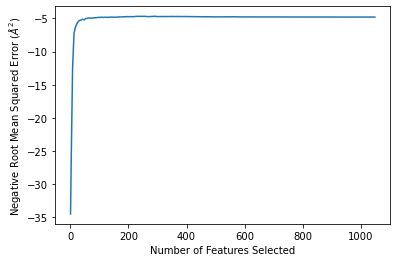

The number of features selected:  238
Selection process completed. 

Modifying descriptor matrices to use only selected descriptors...
New descriptor matrices constructed. 

Scaling descriptor matrices...
Descriptor matrices scaled. 

Building an SVR model with descriptors selected with RFE... 

     Performing grid search hyperparamter optimization...
     Grid search completed.

     Fitting SVR model...
     SVR model constructed.

     Performing k-fold cross-validation...
     Cross-validation completed.

Simplified model completed. 

Performing CCS predictions...
All predictions completed. 

-----------------------------------------------------------------------------------------------------------
MODEL VALIDATION
-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------
                                       CCSP 2.0: All D

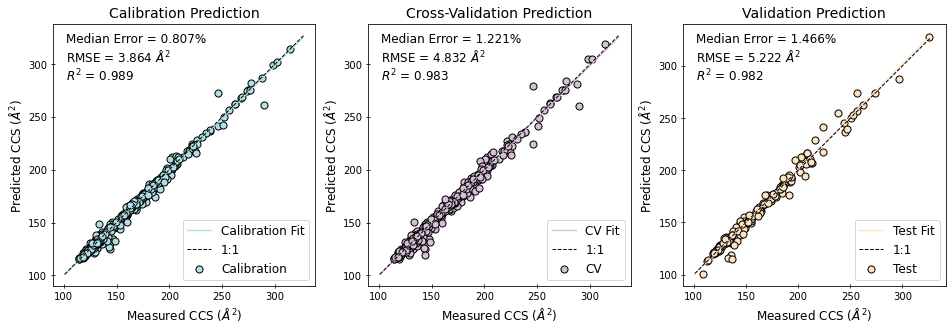

-----------------------------------------------------------------------------------------------------------
                                    CCSP 2.0: RFE Variable Selection
-----------------------------------------------------------------------------------------------------------


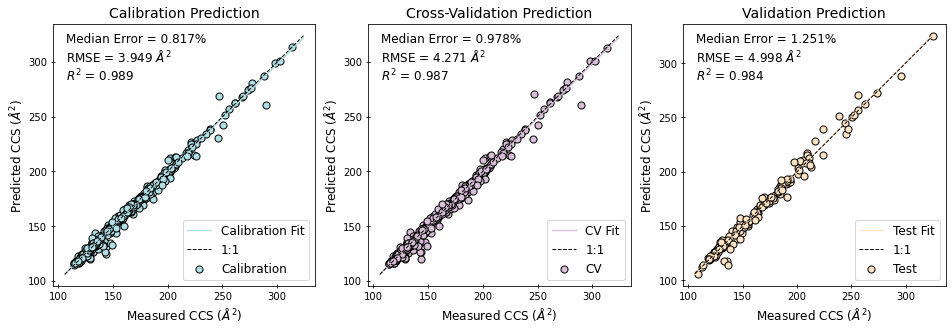

Wall time: 2min 1s


In [10]:
%%time

print("-----------------------------------------------------------------------------------------------------------")
print("DATA PREPARATION")
print("-----------------------------------------------------------------------------------------------------------")

print("Waiting for user to select input files via prompt box...")
Train_Book, Test_Book, Target_Book = select_input_files()
print("Files selected. \n")

print("Checking provided structural identifiers for invalid inputs...")
train_input_type, train_input_errors = check_inputs(Train_Book, column_title='Input')
test_input_type, test_input_errors = check_inputs(Test_Book, column_title='Input')
target_input_type, target_input_errors = check_inputs(Target_Book, column_title='Input')


if len(train_input_errors)+len(test_input_errors)+len(target_input_errors)>0:
    if len(train_input_errors)>0:
        print('Assuming the training input type:', train_input_type, '\n')
        print("The following training inputs returned errors:", '\n')
        for i in train_input_errors:
            print(i, '\n')
    if len(test_input_errors)>0:
        print('Assuming the testing input type:', test_input_type, '\n')
        print("The following testing inputs returned errors:", '\n')
        for i in test_input_errors:
            print(i, '\n')
    if len(target_input_errors)>0:
        print('Assuming the target input type:', target_input_type, '\n')
        print("The following target inputs returned errors:", '\n')
        for i in target_input_errors:
            print(i, '\n')
    print("Please correct these inputs and try again.")
    sys.exit()
if len(train_input_errors)+len(test_input_errors)+len(target_input_errors)==0:
    print("No input errors found. \n")
##################################################################################################################
X_train, y_train, X_test, y_test, X_target = variable_assigner(Train_Book, Test_Book, Target_Book, train_input_type=train_input_type, test_input_type=test_input_type, target_input_type=target_input_type)
print("-----------------------------------------------------------------------------------------------------------")
print("MODEL TRAINING: Building an SVR Model using All Applicable Mordred Descriptors")
print("-----------------------------------------------------------------------------------------------------------")
X_train_clean, X_test_clean, X_target_clean, X_train_scaled, model, grid_results, y_train_predicted, y_train_cross_validation, y_test_predicted, y_target_predicted = initial_ccs_prediction(X_train, y_train, X_test, y_test, X_target, remove_outlier=True, threshold=1000)
print("-----------------------------------------------------------------------------------------------------------")
print("MODEL SIMPLIFICATION: Building an SVR Model using Recursive Feature Elimination")
print("-----------------------------------------------------------------------------------------------------------")
rfecv = rfe_variable_selection(X_train_scaled, y_train, grid_results)

model_rfe, grid_result_rfe, X_test_rfe, y_train_predicted_rfe, y_train_cross_validation_rfe, y_test_predicted_rfe, y_target_predicted_rfe = rfe_ccs_prediction(X_train_clean, y_train, X_test_clean, y_test, X_target_clean, rfecv)

##################################################################################################################
print("-----------------------------------------------------------------------------------------------------------")
print("MODEL VALIDATION")
print("-----------------------------------------------------------------------------------------------------------")
print("-----------------------------------------------------------------------------------------------------------")
print("                                       CCSP 2.0: All Descriptors")
print("-----------------------------------------------------------------------------------------------------------")
summary_plot_all = summary_plot(y_train, y_test, y_train_predicted, y_train_cross_validation, y_test_predicted, labelsize = 12, legendsize = 12, titlesize = 14, textsize = 12)
print("-----------------------------------------------------------------------------------------------------------")
print("                                    CCSP 2.0: RFE Variable Selection")
print("-----------------------------------------------------------------------------------------------------------")
summary_plot_rfe = summary_plot(y_train, y_test, y_train_predicted_rfe, y_train_cross_validation_rfe, y_test_predicted_rfe, labelsize = 12, legendsize = 12, titlesize = 14, textsize = 12)

##################################################################################################################

Train_Book_Output, Test_Book_Output, Target_Book_Output = Train_Book.copy(), Test_Book.copy(), Target_Book.copy()
Train_Book_Output["Calibration CCS Prediction"] = y_train_predicted
Train_Book_Output["Cross-Validation CCS Prediction"] = y_train_cross_validation
Test_Book_Output["Validation CCS Prediction"] = y_test_predicted
Target_Book_Output["Target CCS Prediction"] = y_target_predicted
Train_Book_Output["Calibration CCS Prediction RFE VS"] = y_train_predicted_rfe
Train_Book_Output["Cross-Validation CCS Prediction RFE VS"] = y_train_cross_validation_rfe
Test_Book_Output["Validation CCS Prediction RFE VS"] = y_test_predicted_rfe
Target_Book_Output["Target CCS Prediction RFE VS"] = y_target_predicted_rfe

## Prediction Export

In [11]:
timestr = time.strftime("%Y%m%d-%H%M%S")
win = Tk()
win.geometry("750x250")
save_predictions_boolean = messagebox.askyesno("Question","Would you like to save your predictions?")
if save_predictions_boolean is True:
    ctypes.windll.user32.MessageBoxW(0, "Select the folder where you would like to save your predictions.", "CCSP 2.0", 1)
    output_location = filedialog.askdirectory()
    writer = pd.ExcelWriter(output_location + '/' +'CCSP-Output-' + timestr + '.xlsx', engine='xlsxwriter')
    Train_Book_Output.to_excel(writer, sheet_name='Train_Book_Output')
    Test_Book_Output.to_excel(writer, sheet_name='Test_Book_Output')
    Target_Book_Output.to_excel(writer, sheet_name='Target_Book_Output')
    writer.save()
win.destroy()


## Model Diagnostics Plots for All 2D Descriptors

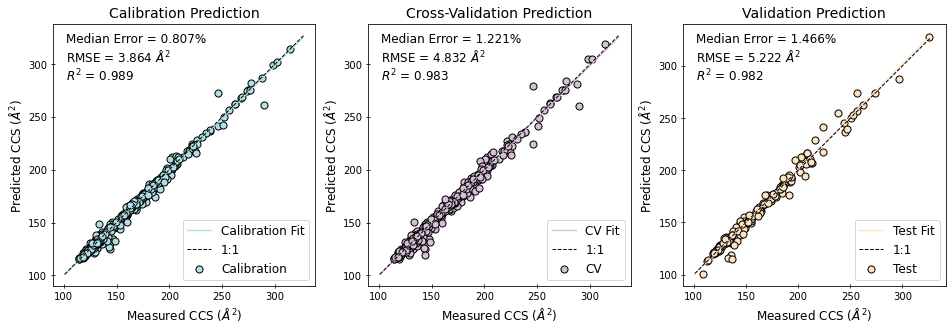

Wall time: 1.8 s


In [12]:
%%time
summary_plot_all = summary_plot(y_train, y_test, y_train_predicted, y_train_cross_validation, y_test_predicted, labelsize = 12, legendsize = 12, titlesize = 14, textsize = 12)
prediction_plot_calibration = prediction_plot(y_train, y_train_predicted, Train_Book, hover_column=['Compound Name'], title_string="Calibration Prediction")
prediction_plot_cross_validation = prediction_plot(y_train, y_train_cross_validation, Train_Book, hover_column=['Compound Name'], title_string="Cross-Validation Prediction")
prediction_plot_validation = prediction_plot(y_test, y_test_predicted, Test_Book, hover_column=['Compound Name'], title_string="Validation Prediction")
model_diagnostic_plot = model_diagnostics_plot(X_test_clean, model)

## Model Diagnostics Plots for RFE Descriptors

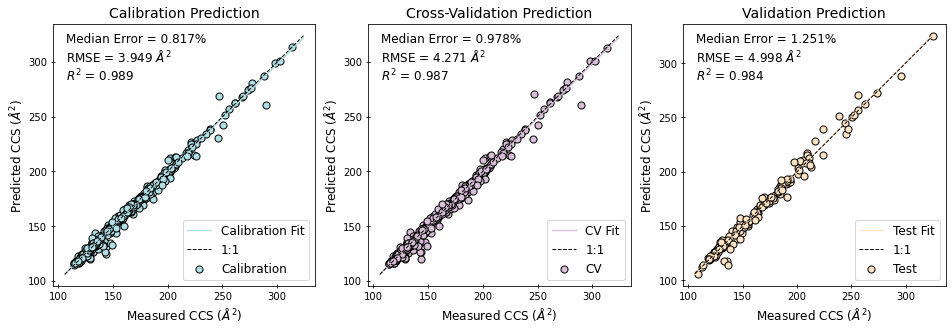

Wall time: 1.55 s


In [13]:
%%time
summary_plot_rfe = summary_plot(y_train, y_test, y_train_predicted_rfe, y_train_cross_validation_rfe, y_test_predicted_rfe, labelsize = 12, legendsize = 12, titlesize = 14, textsize = 12)
prediction_plot_calibration_rfe = prediction_plot(y_train, y_train_predicted_rfe, Train_Book, hover_column=['Compound Name'], title_string="Calibration Prediction")
prediction_plot_cross_validation_rfe = prediction_plot(y_train, y_train_cross_validation_rfe, Train_Book, hover_column=['Compound Name'], title_string="Cross-Validation Prediction")
prediction_plot_validation_rfe = prediction_plot(y_test, y_test_predicted_rfe, Test_Book, hover_column=['Compound Name'], title_string="Validation Prediction")
model_diagnostic_plot_rfe = model_diagnostics_plot(X_test_rfe, model_rfe)

## Plot Export

In [14]:
win = Tk()
win.geometry("750x250")
save_plots_boolean = messagebox.askyesno("Question","Would you like to save your plots?")
if save_plots_boolean is True:
    ctypes.windll.user32.MessageBoxW(0, "Select the folder where you would like to save your plots.", "CCSP 2.0", 1)
    output_location = filedialog.askdirectory()
    os.mkdir(output_location + '/' +'CCSP-Figures-' + timestr)
    plot_list = [summary_plot_all, summary_plot_rfe]
    plot_names = ["summary_plot_all", "summary_plot_rfe"]
    for i in range(len(plot_list)):
        save_location = output_location + '/' +'CCSP-Figures-' + timestr + '/' + plot_names[i] + ".svg"
        print(save_location)
        plot_list[i].savefig(save_location)
    plot_list = [prediction_plot_calibration, prediction_plot_cross_validation, prediction_plot_validation, model_diagnostic_plot,
    prediction_plot_calibration_rfe, prediction_plot_cross_validation_rfe, prediction_plot_validation_rfe, model_diagnostic_plot_rfe]
    plot_names = ["prediction_plot_calibration", "prediction_plot_cross_validation", "prediction_plot_validation", "model_diagnostic_plot",
    "prediction_plot_calibration_rfe", "prediction_plot_cross_validation_rfe", "prediction_plot_validation_rfe", "model_diagnostic_plot_rfe"]
    for i in range(len(plot_list)):
        save_location = output_location + '/' +'CCSP-Figures-' + timestr + '/' + plot_names[i] + ".svg"
        print(save_location)
        plot_list[i].write_image(save_location)    
win.destroy()